In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib import rcParams

In [127]:
rcParams["figure.figsize"] = 6, 6
sns.set(color_codes=True)

In [128]:
df = pd.read_csv("csv/data_no_na.csv")
df.head()

,name,mark,year,mileage,engine_power,fuel,consumption,ecology,gearbox,country,engine_size,accidents,exterior,interior,price
0,ford focus,ford,1999,200900.0,0.205934,Gasoline,7.00,166.000000,Manual,Germany,0.0,0.205934,unknown,unknown,490.0
1,opel vectra,opel,1998,199890.0,0.205934,Gasoline,6.65,162.959621,Manual,Germany,0.0,0.205934,unknown,unknown,490.0
2,ford fiesta,ford,2000,189137.0,0.205934,Gasoline,6.65,162.959621,Manual,Germany,0.0,0.205934,unknown,unknown,499.0
3,renault clio,renault,2004,186500.0,0.205934,Gasoline,5.90,139.000000,Manual,Germany,0.0,0.205934,unknown,unknown,500.0
4,audi a4,audi,1996,195000.0,0.205934,Gasoline,6.65,162.959621,Manual,Germany,0.0,0.205934,unknown,unknown,590.0


In [129]:
df.interior = df.interior.str.replace(" ", "")
df.exterior = df.exterior.str.replace(" ", "")
df.loc[df.mark == "vã¤derstad", "mark"] = "vaderstad"

In [130]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

X = df.drop(["price", "name"], axis=1).copy()
y = df.price.values.copy()

In [131]:
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

In [132]:
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing

categorical_cols = ['mark', 'fuel', 'gearbox', 'country', 'exterior', 'interior']

temp = ColumnTransformer([('cat',
                           preprocessing.OneHotEncoder(),
                           categorical_cols)]).fit(X)
cats = temp.named_transformers_['cat'].categories_
cat_tr = preprocessing.OneHotEncoder(categories=cats, sparse=False)

In [133]:
numerical_cols = ['year', 'mileage', 'engine_power', 'consumption', 'ecology', 'engine_size', 'accidents']
num_tr = preprocessing.StandardScaler()

In [134]:
data_tr = ColumnTransformer([('num', num_tr, numerical_cols), ('cat', cat_tr, categorical_cols)])
data_tr

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['year', 'mileage', 'engine_power',
                                  'consumption', 'ecology', 'engine_size',
                                  'accidents']),
                                ('cat',
                                 OneHotEncoder(categories=[array(['acura', 'alfa', 'aston', 'audi', 'audt', 'bentley', 'bmw',
       'bu...
       'United States'], dtype=object),
                                                           array(['black', 'blue', 'brown', 'gold', 'gray', 'green', 'red', 'silver',
       'tan', 'unknown', 'white'], dtype=object),
                                                           array(['beige', 'black', 'brown', 'gray', 'red', '

In [135]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble

models = [
          KNeighborsRegressor(),
          linear_model.Lasso(),
          linear_model.Ridge(),
          linear_model.ElasticNet(),
          ensemble.GradientBoostingRegressor(),
          ensemble.RandomForestRegressor(),
          ensemble.ExtraTreesRegressor()
]

models_names = ['K-nn','Lasso','Ridge','Elastic','Boost','Forest','Extra']

In [136]:
from sklearn.pipeline import Pipeline

scores, mse, mae = [], [], []

for model in models:
    pipe = Pipeline([
        ("features", data_tr),
        ("model", model)
    ])
    fits = pipe.fit(x_train, y_train)
    scores.append(metrics.r2_score(y_test, fits.predict(x_test)))
    mse.append(metrics.mean_squared_error(y_test, fits.predict(x_test)))    
    mae.append(metrics.mean_absolute_error(y_test, fits.predict(x_test)))    

R:\Work\Anacond\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6564428051.792168, tolerance: 23474144.225803845
  positive)


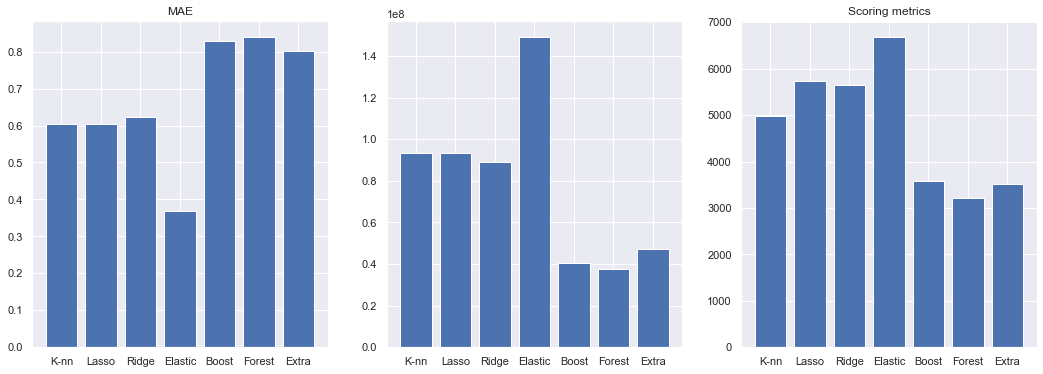

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 6))
plt.title("Scoring metrics")
ax1.set_title("R^2")
ax1.bar(models_names, scores)
ax1.set_title("MSE")
ax2.bar(models_names, mse)
ax1.set_title("MAE")
ax3.bar(models_names, mae)
plt.show()

In [138]:
df_scores = pd.DataFrame(zip(models_names, mse, mae, scores), columns=["model", "mse", "mae", "score"])
df_scores.score = round(df_scores.score * 100, 2)
df_scores.mse = round(df_scores.mse, 1)
df_scores.mae = round(df_scores.mae, 2)
df_scores

,model,mse,mae,score
0,K-nn,93328406.9,4989.68,60.52
1,Lasso,93530232.2,5735.15,60.43
2,Ridge,89259967.4,5649.38,62.24
3,Elastic,149228815.5,6690.75,36.87
4,Boost,40526239.1,3585.85,82.85
5,Forest,37716685.4,3210.68,84.04
6,Extra,47007353.5,3524.95,80.11


In [139]:
model = Pipeline([
    ("features", data_tr),
    ("model", ensemble.RandomForestRegressor(n_estimators=100, min_samples_leaf=1))
])

model.fit(x_train, y_train).score(x_test, y_test)

0.8407400680292112

## Model tuning

In [141]:
from sklearn.model_selection import GridSearchCV

params = {
    'model__n_estimators':[10, 20, 30, 50, 100],
    'model__min_samples_leaf':[1, 2]
}

grids = GridSearchCV(model, param_grid=params, cv=4).fit(x_train, y_train)

grids.best_params_

{'model__min_samples_leaf': 1, 'model__n_estimators': 100}

## Validation

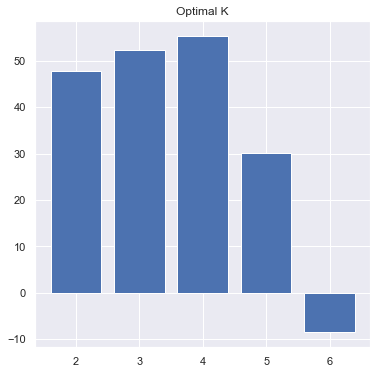

In [153]:
from sklearn.model_selection import cross_validate

test_scores = []

for i in range(2, 7):
    cross_val = cross_validate(model, X, y=y, cv=i, return_train_score=True)
    test_scores.append(cross_val["test_score"].mean().round(4) * 100)

plt.title("Optimal K")
plt.bar(range(2, 7), test_scores)
plt.show()

In [149]:
cross_val = cross_validate(model, X, y=y, cv=4, return_train_score=True)

print("Average train score: ", cross_val["train_score"].mean().round(4) * 100, "%")
print("Average test score: ", cross_val["test_score"].mean().round(4) * 100,"%")

Average train score:  96.86 %
Average test score:  55.26 %


The model is significally overfitting. A solution could be expanding the dataset and then we could try hypertuning the tree model.